In [ ]:
# Importing the libraries needed
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import transformers
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
import logging
logging.basicConfig(level=logging.ERROR)
from torch import cuda
from lib.dataset_utils import *
from lib.plot_utils import *
from lib.models import *
from lib.cross_validation import *
from sklearn.metrics import accuracy_score, jaccard_score, f1_score, multilabel_confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
# Defining some key variables that will be used later on in the training
DATASET_NAME = DatasetEnum.GoEmotionsCleaned
CHECKPOINT_DIR = './checkpoints/'
CHECKPOINT_MODEL_FILE = CHECKPOINT_DIR + 'model.pth'
MINIBATCH_SIZE = 16
EPOCHS = 5
LAMBDA = 1e-04
LEARNING_RATE = 5e-05
FROZEN_LAYERS = 9
# Creating the loss function and optimizer
loss_function = torch.nn.BCEWithLogitsLoss()
train_df, val_df, test_df = load_dataset(DATASET_NAME)
MAX_LEN = compute_max_tokens([train_df, val_df, test_df], RobertaTokenizer.from_pretrained('roberta-base'))
LABEL_COLS = train_df.columns[1:].tolist()

In [ ]:
train_df.head()

,text,admiration,amusement,disapproval,disgust,embarrassment,excitement,fear,gratitude,grief,...,sadness,surprise,neutral,annoyance,approval,caring,confusion,curiosity,desire,disappointment
0,My favourite food is anything I didn't have to...,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,"Now if he does off himself, everyone will thin...",0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,WHY THE FUCK IS BAYLESS ISOING,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,To make her feel threatened,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Dirty Southern Wankers,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [ ]:
THRESHOLD = 0.5
# tuning implicitly done in score calculation :)
def accuracy(y_true, y_pred):
    _, best_res = tune_sigmoid_threshold(y_true, y_pred, accuracy_score)
    return best_res

def jaccard(y_true, y_pred):
    _, best_res = tune_sigmoid_threshold(y_true, y_pred, jaccard_score, {'average': 'macro', 'zero_division': 0})
    return best_res

def jaccard_samples(y_true, y_pred):
    _, best_res = tune_sigmoid_threshold(y_true, y_pred, jaccard_score, {'average': 'samples', 'zero_division': 0})
    return best_res

def f1(y_true, y_pred):
    _, best_res = tune_sigmoid_threshold(y_true, y_pred, f1_score, {'average': 'macro', 'zero_division': 0})
    return best_res

def f1_micro(y_true, y_pred):
    _, best_res = tune_sigmoid_threshold(y_true, y_pred, f1_score, {'average': 'micro', 'zero_division': 0})
    return best_res
'''
weaker accuracy, each prediction is considered correct if its maximum probability class is one of the true classes
'''
def membership_score(y_true, y_pred):
    n_correct = 0
    for t_pattern, p_pattern in zip(y_true, y_pred):
        n_correct += t_pattern[np.argmax(p_pattern)] == 1
    return n_correct / len(y_true)

In [ ]:
# model parameters
PARAMS = {'tokenizer_max_len':MAX_LEN, 
          'batch_size':MINIBATCH_SIZE, 
          'learning_rate':LEARNING_RATE, 
          'epochs':EPOCHS, 
          'loss_function':loss_function, 
          'regularization':LAMBDA,
          'n_classes':len(LABEL_COLS),
          'frozen_layers':FROZEN_LAYERS}
# scores dictionary
SCORES = {'accuracy': accuracy,
          'jaccard_macro': jaccard,
          'f1_macro': f1,
          'jaccard_samples': jaccard_samples,
          'f1_micro':f1_micro,
          'membership':membership_score}
# creating the model
model = Roberta(SCORES,
                PARAMS)                 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.fit(train_df, validation_df=val_df, progress_bar_epoch=True, progress_bar_step=True)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5


  0%|          | 0/2714 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

Epoch 2/5


  0%|          | 0/2714 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

Epoch 3/5


  0%|          | 0/2714 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

Epoch 4/5


  0%|          | 0/2714 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

Epoch 5/5


  0%|          | 0/2714 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

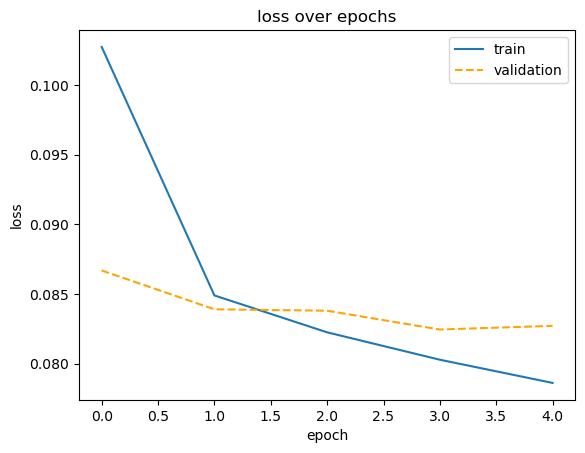

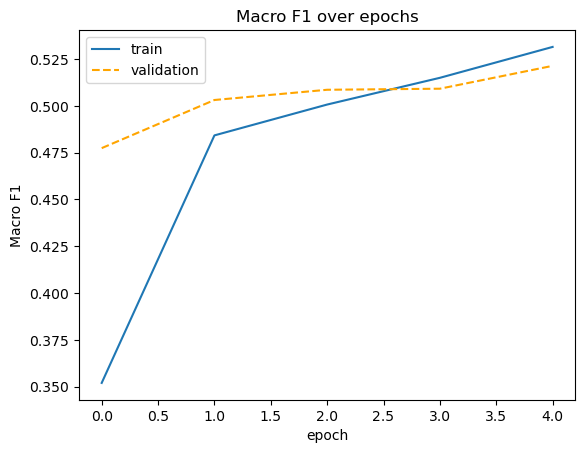

In [ ]:
def plot_learning_curves(tr_loss, val_loss, score_name = 'loss'):
    plt.plot(tr_loss, label='train')
    plt.plot(val_loss, label='validation', color='orange', linestyle='--')
    plt.xlabel('epoch')
    plt.ylabel(score_name)
    plt.legend()
    plt.title(f'{score_name} over epochs')
    plt.show()

# plot learning curves
tr_scores, val_scores = model.get_train_scores(), model.get_val_scores()
tr_loss, val_loss = model.get_train_loss(), model.get_val_loss()

plot_learning_curves(tr_loss, val_loss)
plot_learning_curves(tr_scores['f1_macro'], val_scores['f1_macro'], 'Macro F1')

In [ ]:
out = model.predict(test_df)
target = test_df.iloc[:, 1:].values

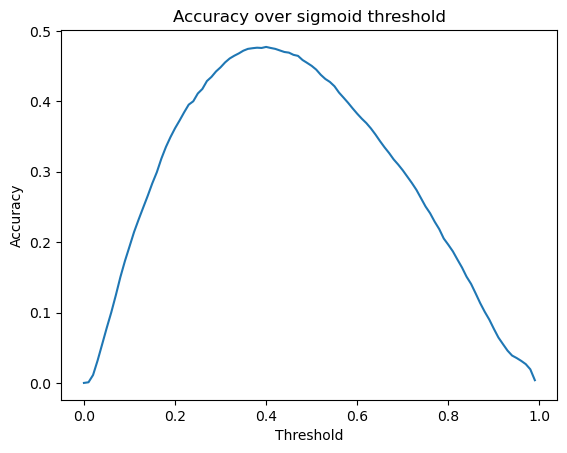

Best threshold: 0.4
Best Accuracy: 0.47724341256679564


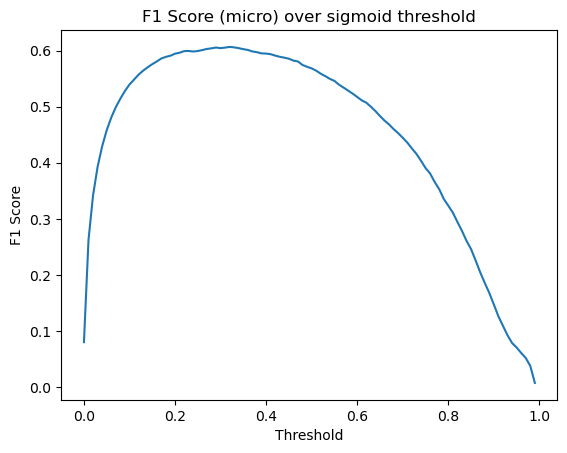

Best threshold: 0.32
Best F1 Score (micro): 0.606556075879038


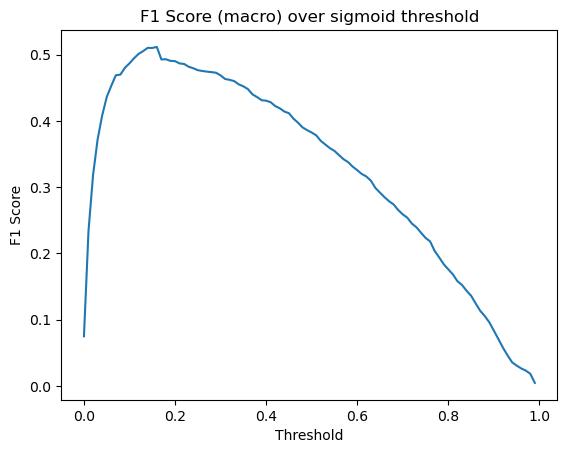

Best threshold: 0.16
Best F1 Score (macro): 0.5118201981702022


In [ ]:
plot_threshold_tuning(target, out, plot=True)
plot_threshold_tuning(target, out, plot=True, metric_params={'average':'micro', 'zero_division':0}, metric_fun=f1_score, metric_name='F1 Score')
plot_threshold_tuning(target, out, plot=True, metric_params={'average':'macro', 'zero_division':0}, metric_fun=f1_score, metric_name='F1 Score')

In [ ]:
# get best threshold
thresh, _ = tune_sigmoid_threshold(target, out, accuracy_score)

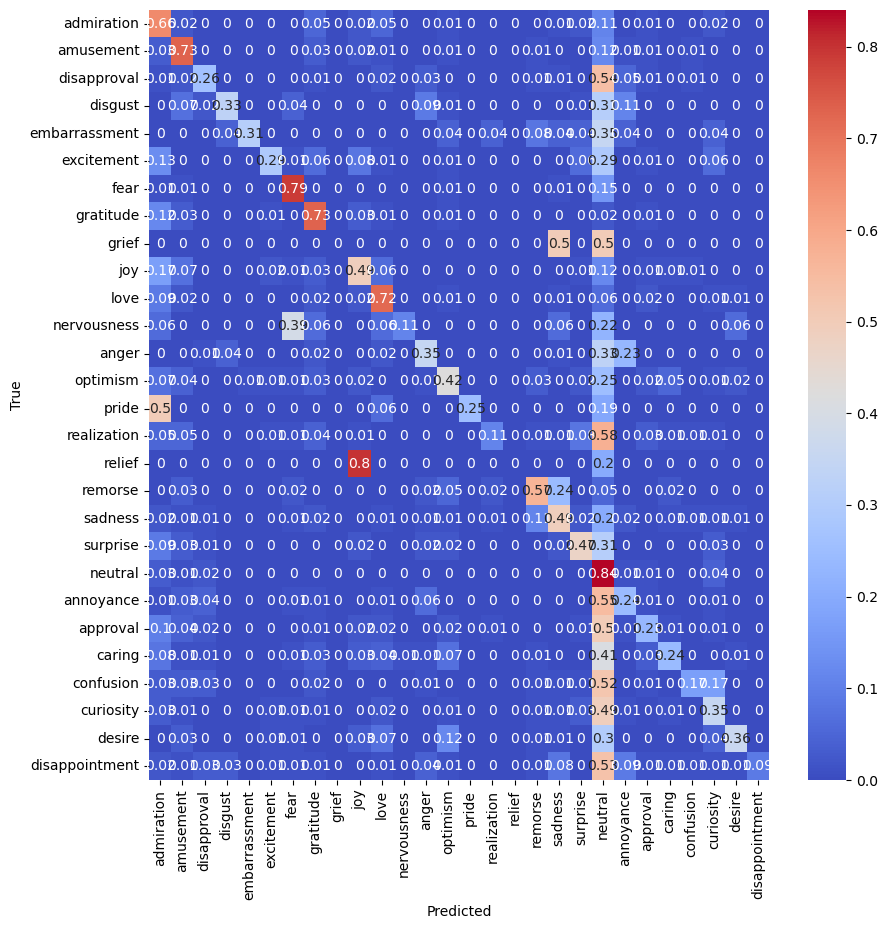

In [ ]:
# plot the confusion matrix for the best threshold
best_out = (out > thresh).astype(int)
plot_multilabel_confusion_heatmap(target, best_out, label_true=test_df.columns[1:], label_pred=test_df.columns[1:], normalize=True)

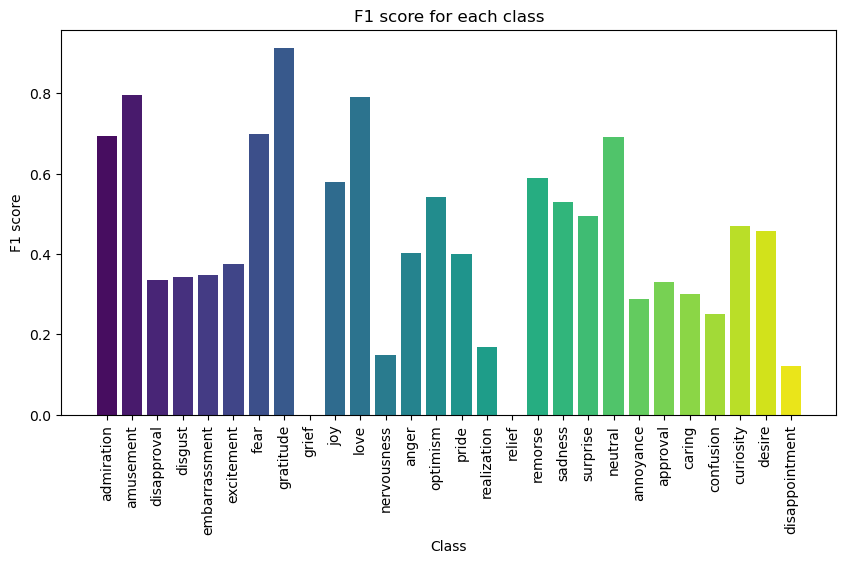

In [ ]:
# bar plot over classes
plot_score_barplot(target, best_out, test_df.columns[1:])

# Cross Validation

In [ ]:
params_to_explore = {
    'learning_rate': [5e-05, 1e-05],
    'regularization': [1e-04, 1e-02],
    'frozen_layers': [9],
    'n_classes': [len(LABEL_COLS)],
}
RESULT_DIR = './results/'
RESULT_FILE = RESULT_DIR + 'GoEmotionsCleaned_Roberta.csv'
# create the grid search object
grid_search = HoldOutCrossValidation(Roberta, SCORES, train_df, val_df, param_dict=params_to_explore, res_file=RESULT_FILE)
# run the grid search
grid_search.run()

In [ ]:
# load the results
results = grid_search.get_results()
# get the best parameters and scores according to F1 macro
best_info = grid_search.get_best_info('f1_macro')
print(best_info)
# print the results
print(results)

In [ ]:
# TODO testing code of bootstrap testing
# bootstrap testing
# n_bootstraps = 5
# n_samples = 100
# scores = []
# bootstrap_test(model, model, test_df, n_bootstraps, n_samples, membership_score, 'membership')